In [1]:
%load_ext autoreload
%autoreload 2
import torch
from transformers import (
    PaliGemmaProcessor,
    PaliGemmaForConditionalGeneration,
    Gemma2Model,
    Gemma2ForCausalLM,
)
from PIL import Image
import matplotlib.pyplot as plt

torch.set_grad_enabled(False)  # avoid blowing up mem
device = "cuda"

In [2]:
model_id = "google/paligemma2-3b-pt-224"
model = (
    PaliGemmaForConditionalGeneration.from_pretrained(
        model_id, torch_dtype=torch.bfloat16
    )
    .to(device)
    .eval()
)
processor = PaliGemmaProcessor.from_pretrained(model_id)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

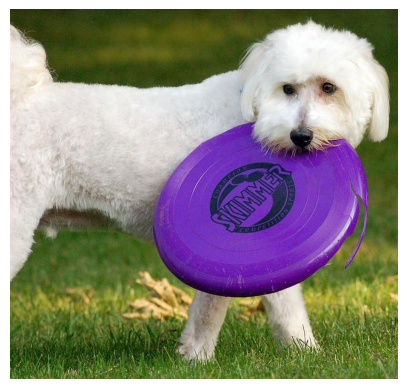

In [3]:
img_path = "imgs/frisbee.jpg"
image = Image.open(img_path)
plt.axis("off")
_ = plt.imshow(image)

In [4]:
from getAttentionLib import get_response


text = "<image>Answer en what is the frisbee's color?"
inputs_tokens, response = get_response(model, processor, text, image)
print("len(inputs_tokens) =", len(inputs_tokens))
print(inputs_tokens)
print(response)

The 'batch_size' attribute of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'self.max_batch_size' attribute instead.


len(inputs_tokens) = 269
['<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<image>', '<imag

In [5]:
object_idxs = (len(inputs_tokens) - 8, len(inputs_tokens) - 2)
print(object_idxs)
print(inputs_tokens[object_idxs[0] : object_idxs[1]])

(261, 267)
[' the', ' fris', 'bee', "'", 's', ' color']


In [6]:
inputs = processor(text=text, images=image, return_tensors="pt").to(model.device)
inputs.keys()

dict_keys(['input_ids', 'attention_mask', 'pixel_values'])

In [7]:
from getAttentionLib import (
    Hook,
    State,
    get_activations,
    paligemma_merge_text_and_image,
    jam_img_embeds,
)

healthy_embeds = paligemma_merge_text_and_image(model, inputs)
healthy_activations, healthy_outputs = get_activations(model, healthy_embeds)
print(processor.decode(healthy_outputs.logits[0, -1, :].argmax()))

The 'batch_size' argument of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'max_batch_size' argument instead.


purple


In [8]:
unhealthy_embeds = jam_img_embeds(healthy_embeds, num_img_tokens=256)
jammed_activations, jammed_outputs = get_activations(model, unhealthy_embeds)
print(processor.decode(jammed_outputs.logits[0, -1, :].argmax()))


auf


In [9]:
from getAttentionLib import purple_prob


assert jammed_activations.shape == healthy_activations.shape
assert purple_prob(processor, healthy_outputs) == model(**inputs).logits[0, -1, :].softmax(dim=-1).max()

In [10]:
# from getAttentionLib import purple_prob


# purple_probs = loop_over_restore_all_activations(
#     model, processor, healthy_activations, jammed_embeds
# )
# torch.save(purple_probs, "purple_probs.pt")

In [11]:
purple_probs = torch.load("purple_probs.pt")

In [12]:
# import plotly.graph_objects as go

# fig = go.Figure(data=go.Heatmap(z=purple_probs))
# fig.update_layout(width=1000, height=1000)
# fig.show()

In [13]:
imgs_max_pool = purple_probs[:, :256].max(dim=1)[0][:, None]
imgs_max_pool.shape, purple_probs[:, 256:].shape

(torch.Size([26, 1]), torch.Size([26, 13]))

In [14]:
pooled_purple_probs = torch.hstack([imgs_max_pool, purple_probs[:, 256:]])

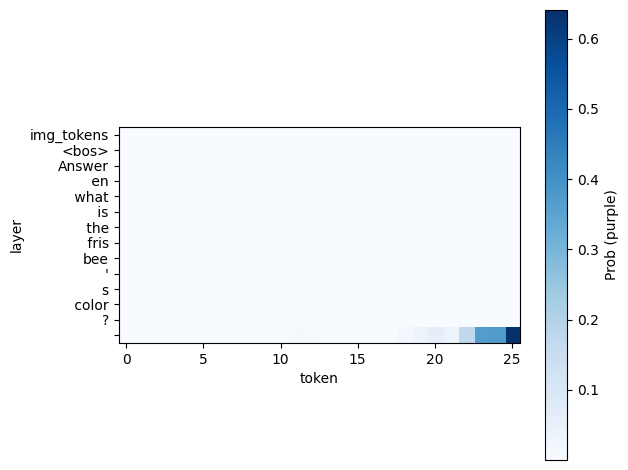

In [15]:
plt.imshow(pooled_purple_probs.T, cmap="Blues")
plt.ylabel("layer")
plt.xlabel("token")
plt.yticks(
    ticks=range(len(pooled_purple_probs.T)), labels=["img_tokens"] + inputs_tokens[256:]
)
cbar = plt.colorbar()
cbar.set_label("Prob (purple)")
plt.tight_layout()
plt.show()

# Does the `<bos>` token get attention?
As we can see below, the noisy input embeddings have a significantly different attention pattern than the healthy image input. 
Almost all attention goes in the image tokens. Almost no attention is allocated to the the `<bos>` token, which explains why it cannot influence the output, even when restored.
This suggests that noise input data disrupts the learned attention patterns. To preserve the attention patterns, we need a different approach to corrput the input image.
Using a different, unrelated image might work better, because it will preserve the attention patterns, as shown in VQA example.

In [16]:
from getAttentionLib import (
    compute_mult_attn_sums,
    plot_region_attn_progression,
    plot_mult_attn_sums,
)

mult_attn_sums = compute_mult_attn_sums(
    model,
    {"inputs_embeds": unhealthy_embeds},
    layers=list(range(len(model.language_model.model.layers))),
    n_img_tokens=256,
)

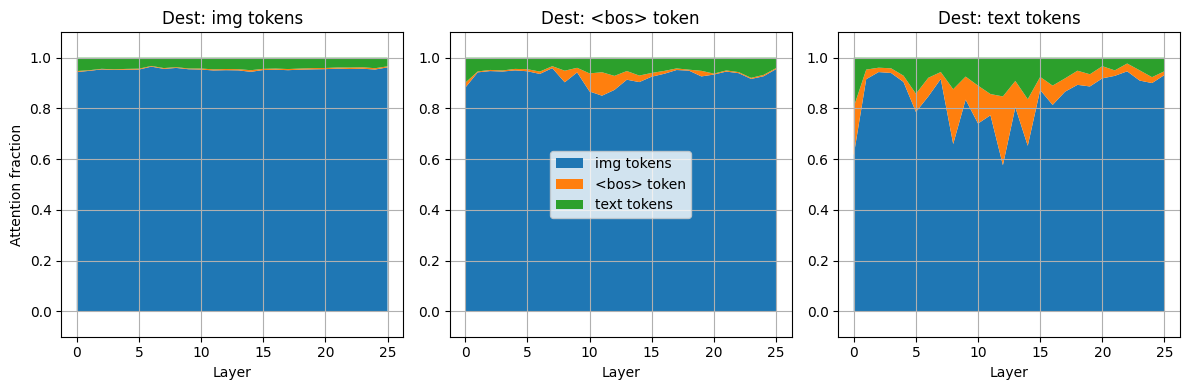

In [17]:
# plot_mult_attn_sums(
#     None, None, layers=[0, 15, 25], mult_attn_sums=mult_attn_sums
# ).show()
plot_region_attn_progression(None, None, mult_attn_sums=mult_attn_sums).show()

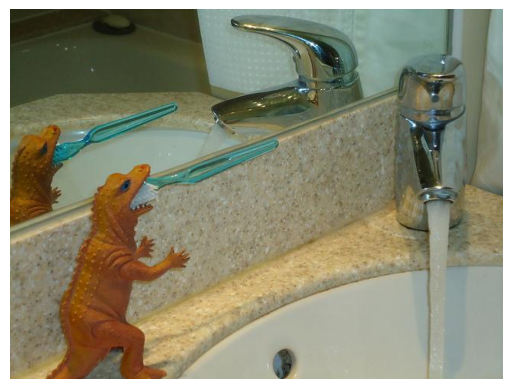

In [18]:
dino_image = Image.open("imgs/dino.jpg")
plt.axis("off")
_ = plt.imshow(dino_image)

In [19]:
dino_inputs = processor(text=text, images=dino_image, return_tensors="pt").to(model.device)
dino_embeds = paligemma_merge_text_and_image(model, dino_inputs)

SyntaxError: invalid syntax (3249736909.py, line 2)